### Required Libraries and Constants

In [60]:
from datetime import datetime
import os
import re
import zipfile
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Set Pandas options to display all rows and columns for better visibility
# pd.set_option('display.max_rows', None)    # Show all rows
# pd.set_option('display.max_columns', None) # Show all columns

In [61]:
# Define the start and end dates
START_DATE = '2023-07-01'
END_DATE = '2024-06-30'

# Convert date strings to datetime objects
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
end_date = datetime.strptime(END_DATE, '%Y-%m-%d')

# Calculate the number of days between the two dates (inclusive of the start date)
NUM_DAYS = (end_date - start_date).days + 1

# Output the number of days
print(f'The number of days between {START_DATE} and {END_DATE} is {NUM_DAYS} days.')

The number of days between 2023-07-01 and 2024-06-30 is 366 days.


### Extract and Relocate Station CSV Files from Zip Archives

In [62]:
def extract_csv_from_zips(zip_directory, csv_output_directory):
    """
    Extracts CSV files from zip files in the specified directory and saves them to the output directory.

    Parameters:
    - zip_directory (str): Directory containing zip files.
    - csv_output_directory (str): Directory to save extracted CSV files.
    """
    # Make sure the output directory exists
    os.makedirs(csv_output_directory, exist_ok=True)

    # Iterate over each file in the zip directory
    for item in os.listdir(zip_directory):
        if item.endswith('.zip'):
            zip_path = os.path.join(zip_directory, item)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # List all files in the zip
                file_list = zip_ref.namelist()
                # Extract only the CSV files
                for file in file_list:
                    if file.endswith('.csv'):
                        # Check if the file already exists in the output directory
                        output_file_path = os.path.join(csv_output_directory, os.path.basename(file))
                        if os.path.exists(output_file_path):
                            print(f"File {file} already exists in the output directory. Skipping extraction.")
                            continue
                        # Extract and save to the output directory
                        zip_ref.extract(file, csv_output_directory)
                        print(f"Extracted {file} to {csv_output_directory}")

    print("All CSV files have been processed.")

# Usage
extract_csv_from_zips(
    'data/raw_data/stations_zipped', 
    'data/raw_data/stations'
)

File IDCJAC0011_1007_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_1019_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10286_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10692_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10905_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10911_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10916_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_10917_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_11003_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_11052_1800_Data.csv already exists in the output directory. Skipping extraction.
File IDCJAC0011_11053_1800_Data.

In [63]:
# Count the number of CSV files in the directory
csv_files_count = len([file for file in os.listdir('data/raw_data/stations') if file.endswith('.csv')])

print(f'Number of CSV files: {csv_files_count}')

Number of CSV files: 350


### Aggregate All Station Information into a Single CSV File

In [64]:
def parse_line(line):
    """
    Parse a line of station data into its components.

    Args:
        line (str): A line of station data.

    Returns:
        tuple: Parsed values or None if the line does not match the expected format.
    """
    pattern = r'(\d+)\s+(.+?)\s+([-]?\d+\.\d+)\s+([-]?\d+\.\d+)\s+(\w+\s+\d+)\s+(\w+\s+\d+)\s+([\d.]+)\s+(\d+)\s+([\d.]+)\s+(\w)'
    match = re.match(pattern, line.strip())
    return match.groups() if match else None

def get_stations(input_file, output_file, start_date, end_date):
    """
    Extract and process station data from a text file and save it to a CSV file.

    Args:
        input_file (str): Path to the input text file with station data.
        output_file (str): Path to the output CSV file.
        start_date (str): The start date to filter the stations.
        end_date (str): The end date to filter the stations.
    """
    try:
        # Read lines from input file
        with open(input_file, 'r') as f:
            station_lines = f.readlines()

        # Remove header and footer
        station_lines = station_lines[4:-6]

        parsed_stations = []
        missed_stations = []

        # Process each line
        for i, line in enumerate(station_lines):
            group = parse_line(line)
            if group:
                parsed_stations.append(group)
            else:
                missed_stations.append(i)
        
        # Print missed lines if necessary
        # for i in missed_stations:
        #     print(station_lines[i])

        # Create DataFrame from parsed data
        columns = ['Site', 'Name', 'Lat', 'Long', 'Start', 'End', 'Years', '%', 'Obs', 'AWS']
        df = pd.DataFrame(parsed_stations, columns=columns)

        # Convert columns to appropriate data types
        df['Site'] = pd.to_numeric(df['Site'])
        df['Lat'] = pd.to_numeric(df['Lat'])
        df['Long'] = pd.to_numeric(df['Long'])
        df['Start'] = pd.to_datetime(df['Start'], format='%b %Y')
        df['End'] = pd.to_datetime(df['End'], format='%b %Y')

        # Drop unnecessary columns
        df.drop(columns=['Years', '%', 'Obs', 'AWS'], inplace=True)

        # Filter based on date range
        filtered_df = df[(df['Start'] < pd.to_datetime(start_date)) & (df['End'] > pd.to_datetime(end_date))]

        # Save the results to a CSV file
        filtered_df.to_csv(output_file, index=False)
        print(f"Data successfully written to {output_file}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Usage
get_stations(
    'data/raw_data/stations/stations.txt',
    'data/aggregated_data/stations_From20230701.csv',
    START_DATE,
    END_DATE
)

Data successfully written to data/aggregated_data/stations_From20230701.csv


In [65]:
stations_From20230701 = pd.read_csv('data/aggregated_data/stations_From20230701.csv')
stations_From20230701

,Site,Name,Lat,Long,Start,End
0,23000,ADELAIDE (WEST TERRACE / NGAYIRDAPIRA),-34.9257,138.5832,1955-01-01,2024-07-01
1,23034,ADELAIDE AIRPORT,-34.9524,138.5196,1955-02-01,2024-07-01
2,200735,ADELE ISLAND,-15.5114,123.1556,1973-09-01,2024-07-01
3,90180,AIREYS INLET,-38.4583,144.0883,1990-07-01,2024-07-01
4,9999,ALBANY AIRPORT,-34.9411,117.8158,2012-01-01,2024-07-01
...,...,...,...,...,...,...
546,81124,YARRAWONGA,-36.0294,146.0305,1993-05-01,2024-07-01
547,33294,YEPPOON THE ESPLANADE,-23.1364,150.7506,1993-11-01,2024-07-01
548,73138,YOUNG AIRPORT,-34.2493,148.2475,1989-08-01,2024-07-01
549,15635,YULARA AIRPORT,-25.1896,130.9737,1983-06-01,2024-07-01


In [66]:
stations_From20230701.dtypes

Site       int64
Name      object
Lat      float64
Long     float64
Start     object
End       object
dtype: object

In [67]:
stations_From20230701.isnull().sum()

Site     0
Name     0
Lat      0
Long     0
Start    0
End      0
dtype: int64

### Process Station CSV Files and Aggregate Date and Temperature Data into a Single CSV File

In [68]:
def process_csv_files(input_folder, output_file, start_date, end_date, num_days):
    """
    Process and aggregate temperature data from CSV files in the specified folder.

    Args:
        input_folder (str): Path to the folder containing CSV files.
        output_file (str): Path to the output CSV file.
        start_date (str): Start date for filtering data (format: 'YYYY-MM-DD').
        end_date (str): End date for filtering data (format: 'YYYY-MM-DD').
        num_days (int): Number of days of data expected for validation.

    Returns:
        None
    """
    # Define column names for consistency across all files
    col_names = ['Product_code', 'Station', 'Year', 'Month', 'Day', 'Min_temp', 'Days_of_accumulation_of_min_temp', 'Quality']

    # Convert start_date and end_date to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Initialise an empty list to collect DataFrames
    dfs = []

    # Iterate through each file in the directory
    for filename in os.listdir(input_folder):
        if filename.endswith('.csv'):
            # Extract station name from filename
            station_name = filename[11:-14]
            
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(os.path.join(input_folder, filename), names=col_names, header=0)
                
                # Perform assertions
                assert np.array_equal(df['Product_code'].unique(), np.array(['IDCJAC0011']))
                assert np.array_equal(df['Station'].unique(), np.array([int(station_name)]))

                # Convert Year, Month, Day to datetime
                df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

                # Filter rows where date is within the specified range
                df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
                
                # Validate the number of rows
                if len(df) != num_days:
                    print(f'{filename} discarded as dataset is incomplete ({len(df)} rows).')
                    continue

                # Drop unnecessary columns
                df.drop(columns=['Product_code', 'Year', 'Month', 'Day', 'Days_of_accumulation_of_min_temp', 'Quality'], inplace=True)

                # Rearrange columns
                df = df[['Station', 'Date', 'Min_temp']]
                
                # Fill NaN values in 'Min_temp' with the rounded mean of the surrounding 7 days and ensure first index is filled
                first_valid_index = df['Min_temp'].first_valid_index()
                df['Min_temp'].iloc[0] = df['Min_temp'].loc[first_valid_index]
                while df['Min_temp'].isnull().sum() > 0:
                    df['Min_temp'] = df['Min_temp'].fillna(df['Min_temp'].rolling(window=7, min_periods=1).mean().round(1))
                
                # Append the processed DataFrame to the list
                dfs.append(df)

                print(f'{filename} parsed!')

            except Exception as e:
                print(f'Error processing {filename}: {e}')

    # Concatenate all DataFrames in the list into one
    final_df = pd.concat(dfs, ignore_index=True)

    # Save dataframe as CSV
    final_df.to_csv(output_file, index=False)
    print(f'All files processed. Data saved to {output_file}')

# Usage
process_csv_files(
    'data/raw_data/stations',
    'data/aggregated_data/temperatures_From20230701.csv',
    START_DATE,
    END_DATE,
    NUM_DAYS
)


IDCJAC0011_1007_1800_Data.csv parsed!
IDCJAC0011_1019_1800_Data.csv parsed!
IDCJAC0011_10286_1800_Data.csv parsed!
IDCJAC0011_10692_1800_Data.csv parsed!
IDCJAC0011_10905_1800_Data.csv parsed!
IDCJAC0011_10911_1800_Data.csv parsed!
IDCJAC0011_10916_1800_Data.csv parsed!
IDCJAC0011_10917_1800_Data.csv parsed!
IDCJAC0011_11003_1800_Data.csv parsed!
IDCJAC0011_11052_1800_Data.csv parsed!
IDCJAC0011_11053_1800_Data.csv parsed!
IDCJAC0011_12009_1800_Data.csv parsed!
IDCJAC0011_12038_1800_Data.csv parsed!
IDCJAC0011_12071_1800_Data.csv parsed!
IDCJAC0011_12305_1800_Data.csv parsed!
IDCJAC0011_12314_1800_Data.csv parsed!
IDCJAC0011_12320_1800_Data.csv parsed!
IDCJAC0011_13011_1800_Data.csv parsed!
IDCJAC0011_13017_1800_Data.csv parsed!
IDCJAC0011_13030_1800_Data.csv parsed!
IDCJAC0011_14015_1800_Data.csv parsed!
IDCJAC0011_14142_1800_Data.csv parsed!
IDCJAC0011_14198_1800_Data.csv parsed!
IDCJAC0011_14272_1800_Data.csv parsed!
IDCJAC0011_14274_1800_Data.csv parsed!
IDCJAC0011_14401_1800_Data.

In [69]:
temperatures_From20230701 = pd.read_csv('data/aggregated_data/temperatures_From20230701.csv')
temperatures_From20230701

,Station,Date,Min_temp
0,1007,2023-07-01,22.4
1,1007,2023-07-02,22.4
2,1007,2023-07-03,22.4
3,1007,2023-07-04,22.4
4,1007,2023-07-05,22.4
...,...,...,...
128095,9968,2024-06-26,6.1
128096,9968,2024-06-27,8.3
128097,9968,2024-06-28,7.8
128098,9968,2024-06-29,5.9


In [70]:
temperatures_From20230701.dtypes

Station       int64
Date         object
Min_temp    float64
dtype: object

In [71]:
temperatures_From20230701.isnull().sum()

Station     0
Date        0
Min_temp    0
dtype: int64

In [72]:
temperatures_From20230701.Min_temp.min()

-39.3

In [73]:
temperatures_From20230701.Min_temp.max()

33.5

### Combine Stations and Temperatures Data into a Single CSV File

In [74]:
def merge_and_save_data(temperatures_file, stations_file, output_file):
    """
    Merge temperature data with station data and save the result to a CSV file.

    Args:
        temperatures_file (str): Path to the CSV file containing temperature data.
        stations_file (str): Path to the CSV file containing station data.
        output_file (str): Path to the output CSV file where merged data will be saved.

    Returns:
        None
    """
    # Load the CSV files into DataFrames
    temperatures = pd.read_csv(temperatures_file)
    stations = pd.read_csv(stations_file)

    # Merge the DataFrames on the 'Station' and 'Site' columns
    merged_df = pd.merge(temperatures, stations, left_on='Station', right_on='Site', how='left')

    # Select the relevant columns for the final output
    merged_df = merged_df[['Station', 'Name', 'Lat', 'Long', 'Date', 'Min_temp']]

    # Save the merged DataFrame to a CSV file
    merged_df.to_csv(output_file, index=False)

    print(f'Merged data saved to {output_file}')

# Usage
merge_and_save_data(
    'data/aggregated_data/temperatures_From20230701.csv',
    'data/aggregated_data/stations_From20230701.csv',
    'data/aggregated_data/stations_with_temperatures_From20230701.csv'
)


Merged data saved to data/aggregated_data/stations_with_temperatures_From20230701.csv


In [75]:
stations_with_temperatures_From20230701 = pd.read_csv('data/aggregated_data/stations_with_temperatures_From20230701.csv')
stations_with_temperatures_From20230701

,Station,Name,Lat,Long,Date,Min_temp
0,1007,TROUGHTON ISLAND,-13.7542,126.1485,2023-07-01,22.4
1,1007,TROUGHTON ISLAND,-13.7542,126.1485,2023-07-02,22.4
2,1007,TROUGHTON ISLAND,-13.7542,126.1485,2023-07-03,22.4
3,1007,TROUGHTON ISLAND,-13.7542,126.1485,2023-07-04,22.4
4,1007,TROUGHTON ISLAND,-13.7542,126.1485,2023-07-05,22.4
...,...,...,...,...,...,...
128095,9968,SHANNON,-34.5683,116.3367,2024-06-26,6.1
128096,9968,SHANNON,-34.5683,116.3367,2024-06-27,8.3
128097,9968,SHANNON,-34.5683,116.3367,2024-06-28,7.8
128098,9968,SHANNON,-34.5683,116.3367,2024-06-29,5.9


In [76]:
stations_with_temperatures_From20230701.dtypes

Station       int64
Name         object
Lat         float64
Long        float64
Date         object
Min_temp    float64
dtype: object

In [77]:
stations_with_temperatures_From20230701.isnull().sum()

Station     0
Name        0
Lat         0
Long        0
Date        0
Min_temp    0
dtype: int64

### Aggregate Temperature Data for Postcode Regions

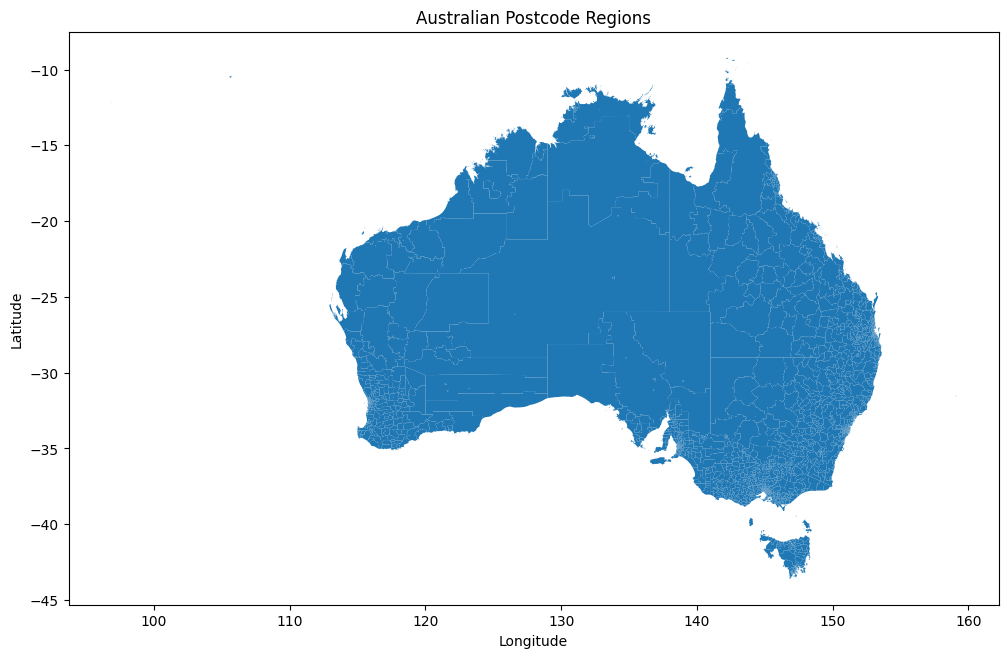

In [78]:
# Load the GeoJSON file containing Australian postcode regions
aus_regions = gpd.read_file('data/raw_data/regions/au-postcodes-Visvalingam-5.geojson')

# Create a figure with specified dimensions
fig, ax = plt.subplots(figsize=(12, 10))  # Width, Height in inches

# Plot the GeoDataFrame
aus_regions.plot(ax=ax)

# Set plot title and axis labels
plt.title('Australian Postcode Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [79]:
aus_regions

,POA_CODE,POA_NAME,SQKM,geometry
0,0800,0800,3.123064,"POLYGON ((130.85017 -12.45301, 130.84974 -12.4..."
1,0810,0810,24.428581,"POLYGON ((130.84584 -12.4026, 130.84873 -12.39..."
2,0812,0812,35.889912,"POLYGON ((130.90521 -12.33467, 130.91177 -12.3..."
3,0820,0820,39.051721,"POLYGON ((130.84584 -12.4026, 130.8561 -12.402..."
4,0822,0822,144468.865099,"MULTIPOLYGON (((136.74937 -12.22949, 136.75021..."
...,...,...,...,...
2508,7331,7331,1.887435,"POLYGON ((145.28415 -40.77254, 145.27947 -40.7..."
2509,7467,7467,3.505876,"POLYGON ((145.55942 -42.06602, 145.56388 -42.0..."
2510,7468,7468,4.536087,"POLYGON ((145.30773 -42.14892, 145.31216 -42.1..."
2511,7469,7469,2133.823111,"POLYGON ((145.10136 -41.64595, 145.33667 -41.6..."


In [80]:
aus_regions.POA_CODE.nunique()

2513

In [81]:
def get_temperatures_for_regions(csv_file, geojson_file, output_file, start_date, end_date, crs="EPSG:4326"):
    """
    Calculate average temperatures for each postcode region based on temperature station data.

    Args:
        csv_file (str): Path to the CSV file with temperature station data.
        geojson_file (str): Path to the GeoJSON file with postcode regions.
        output_file (str): Path to the output CSV file to save results.
        crs (str): Coordinate Reference System to use for spatial operations.
        start_date (str): Start date for filtering temperature data.
        end_date (str): End date for filtering temperature data.

    Returns:
        None
    """
    # Load the GeoJSON file into a GeoDataFrame
    geo_df = gpd.read_file(geojson_file).to_crs(crs)

    # Load the CSV file into a DataFrame
    data_df = pd.read_csv(csv_file)

    # Prepare a GeoDataFrame for stations
    stations_df = data_df[['Station', 'Name', 'Lat', 'Long']].drop_duplicates()
    stations_gdf = gpd.GeoDataFrame(
        stations_df, 
        geometry=gpd.points_from_xy(stations_df['Long'], stations_df['Lat']),
        crs=crs
    )

    # Spatial join to find stations within each postcode region
    joined = gpd.sjoin(stations_gdf, geo_df, how='right', predicate='within')

    # Group by postcode and aggregate stations into lists
    station_postcodes = joined.groupby('POA_CODE')['Station'].apply(
        lambda x: [int(station) for station in x.dropna()]
    ).reset_index()

    # Identify postcodes with no stations
    no_station_postcodes = station_postcodes[station_postcodes['Station'].map(len) == 0].sort_values(by='POA_CODE').reset_index(drop=True)

    # Handle postcodes with no stations
    if not no_station_postcodes.empty:
        # Add geometry to postcodes with no stations
        postcodes_with_geom = no_station_postcodes.merge(geo_df[['POA_CODE', 'geometry']], on='POA_CODE')
        postcodes_with_geom = gpd.GeoDataFrame(postcodes_with_geom, geometry='geometry').to_crs(crs)

        # Re-project geometries for distance calculations
        postcodes_with_geom_projected = postcodes_with_geom.to_crs('EPSG:3857')
        postcode_centroids = postcodes_with_geom_projected.geometry.centroid
        postcode_centroids = postcode_centroids.to_crs(crs)

        # Create KDTree for station points
        station_coords = np.array(list(stations_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
        station_tree = cKDTree(station_coords)

        # Find the nearest station for each postcode
        def find_nearest_station(postcode_centroid):
            centroid_coords = (postcode_centroid.x, postcode_centroid.y)
            _, idx = station_tree.query(centroid_coords)
            return [stations_gdf.iloc[idx]['Station']]

        no_station_postcodes['Station'] = postcode_centroids.apply(find_nearest_station)

    # Combine results for postcodes with and without stations
    full_station_postcodes = pd.concat([
        station_postcodes[station_postcodes['Station'].map(len) > 0],
        no_station_postcodes
    ]).sort_values(by='POA_CODE').reset_index(drop=True)

    # Query temperature data and aggregate
    def query_temperatures(row):
        postcode = row['POA_CODE']
        stations = row['Station']

        # Filter temperature data for the relevant stations and date range
        filtered_df = data_df[(data_df['Station'].isin(stations)) & 
                              (data_df['Date'] >= start_date) & 
                              (data_df['Date'] <= end_date)]
        filtered_df = filtered_df.groupby('Date')['Min_temp'].mean().reset_index()

        filtered_df['Postcode'] = postcode
        filtered_df = filtered_df.rename(columns={'Min_temp': 'Avg_temp'})
        filtered_df = filtered_df[['Postcode', 'Date', 'Avg_temp']]

        return filtered_df

    # Apply the temperature query function to all postcodes
    postcodes_with_temperatures = pd.concat(full_station_postcodes.apply(query_temperatures, axis=1).tolist(), ignore_index=True)

    # Save the results to a CSV file
    postcodes_with_temperatures.to_csv(output_file, index=False)
    print(f'Temperature data saved to {output_file}')

# Example usage
get_temperatures_for_regions(
    'data/aggregated_data/stations_with_temperatures_From20230701.csv',
    'data/raw_data/regions/au-postcodes-Visvalingam-5.geojson',
    'data/aggregated_data/postcodes_with_temperatures_From20230701.csv',
    START_DATE,
    END_DATE
)

Temperature data saved to data/aggregated_data/postcodes_with_temperatures_From20230701.csv


In [82]:
postcodes_with_temperatures_From20230701 = pd.read_csv('data/aggregated_data/postcodes_with_temperatures_From20230701.csv')
postcodes_with_temperatures_From20230701

,Postcode,Date,Avg_temp
0,800,2023-07-01,22.3
1,800,2023-07-02,20.4
2,800,2023-07-03,20.1
3,800,2023-07-04,20.8
4,800,2023-07-05,21.8
...,...,...,...
919753,7470,2024-06-26,1.9
919754,7470,2024-06-27,0.4
919755,7470,2024-06-28,1.4
919756,7470,2024-06-29,1.6


In [83]:
postcodes_with_temperatures_From20230701.dtypes

Postcode      int64
Date         object
Avg_temp    float64
dtype: object

In [84]:
postcodes_with_temperatures_From20230701.isnull().sum()

Postcode    0
Date        0
Avg_temp    0
dtype: int64

In [85]:
postcodes_with_temperatures_From20230701['Postcode'].nunique()

2513

In [86]:
postcodes_with_temperatures_From20230701['Date'].min()

'2023-07-01'

In [87]:
postcodes_with_temperatures_From20230701['Date'].max()

'2024-06-30'

In [88]:
postcodes_with_temperatures_From20230701['Avg_temp'].min()

-10.8

In [89]:
postcodes_with_temperatures_From20230701['Avg_temp'].max()

33.5